In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import struct
from scipy.signal import butter, filtfilt, firls, iircomb, resample_poly, decimate, envelope

In [28]:
path = 'mediciones_simultaneas/DAVID171225_4-JORGE-20051201024404/bmecg'

with open(path, 'rb') as f:
    raw_data = f.read()

# 1. Parse the Header
# The file starts with "BMECG1" followed by a JSON object
header_start = 6  # Skip "BMECG1"
header_end = raw_data.find(b'}}') + 2
header_json = raw_data[header_start:header_end].decode('utf-8')
header = json.loads(header_json)

print("Header parsed successfully!")
print(f"Sampling Rate: {header['ecg']['samplingRate']} Hz")
print(f"Channels: {header['ecg']['channels']}")

# 2. Find Data Start
# Skip null bytes padding after the JSON header
data_start = header_end
while data_start < len(raw_data) and raw_data[data_start] == 0:
    data_start += 1

print(f"Data starts at byte: {data_start}")

# 3. Read Signal Data
# 'short' format usually means 16-bit signed integer (int16)
num_channels = len(header['ecg']['channels'])
signal_data = np.frombuffer(raw_data, dtype=np.int16, offset=data_start)

# Reshape data: (Samples, Channels)
# We truncate any extra bytes that don't fit perfectly into the shape
num_samples = len(signal_data) // num_channels
signal_data = signal_data[:num_samples * num_channels]
ecg_signal = signal_data.reshape(num_samples, num_channels)
print(f"ECG Signal Shape: {ecg_signal.shape}")
ecg_signal = ecg_signal[:, :12]  # Keep only first 12 channels if more are present

Header parsed successfully!
Sampling Rate: 500 Hz
Channels: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'CM5', 'CR5']
Data starts at byte: 4096
ECG Signal Shape: (602084, 14)


In [29]:
# bandpass filter between 0.5 Hz and 150 Hz for ECG signal channel 2
lowcut = 0.5
highcut = 150.0
fs = header['ecg']['samplingRate']
order = 5
b, a = butter(order, [lowcut, highcut], btype='bandpass', fs=fs)
b2, a2 = butter(order+1, [lowcut, highcut], btype='bandpass', fs=fs)

# comb filter at w0=50 Hz to remove powerline noise
w0 = 50.0  # Frequency to be removed from signal (Hz)
quality_factor = 30.0  # Quality factor
b_notch, a_notch = iircomb(w0, quality_factor, ftype='notch', fs=fs)
ecg_signal = np.array(ecg_signal)
ecg_signal = ecg_signal.astype(np.float32)

ecg_signal = filtfilt(b, a, ecg_signal, axis=0)
ecg_signal = filtfilt(b_notch, a_notch, ecg_signal, axis=0)
ecg_signal = filtfilt(b2, a2, ecg_signal, axis=0)

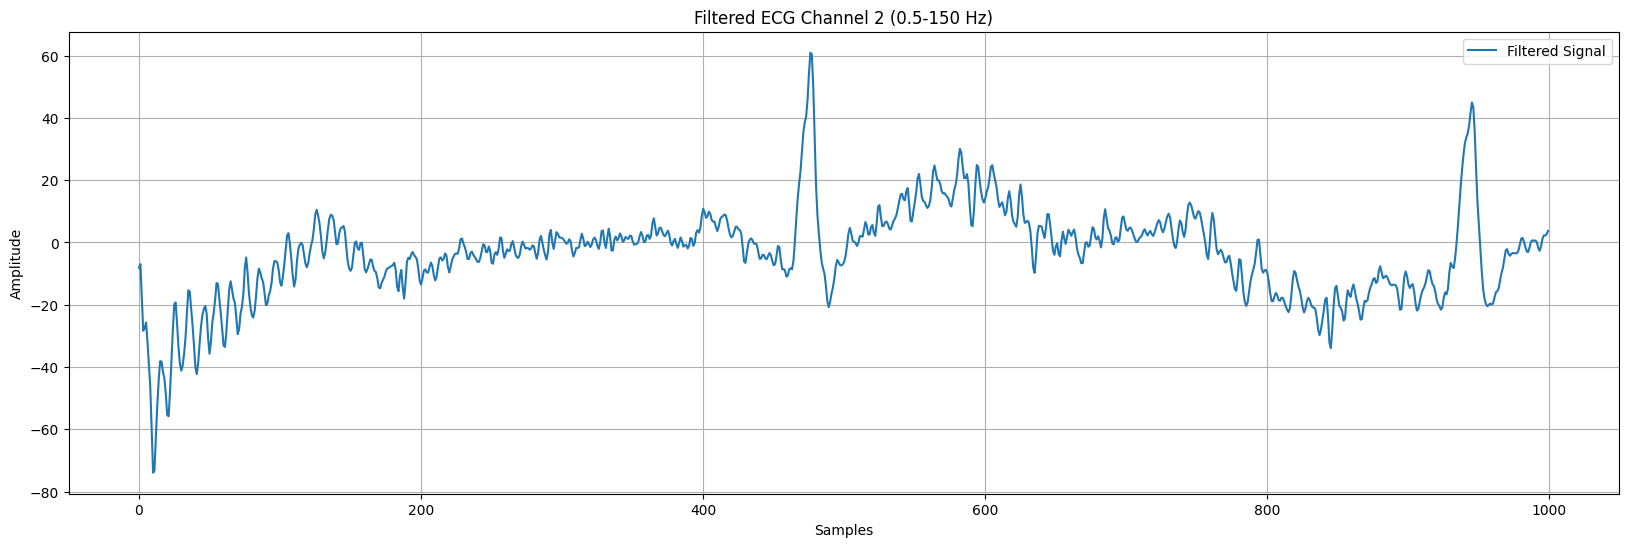

In [30]:
plt.figure(figsize=(20, 6))
plt.plot(ecg_signal[:1000, 1], label='Filtered Signal')
plt.title('Filtered ECG Channel 2 (0.5-150 Hz)')
plt.grid(True)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

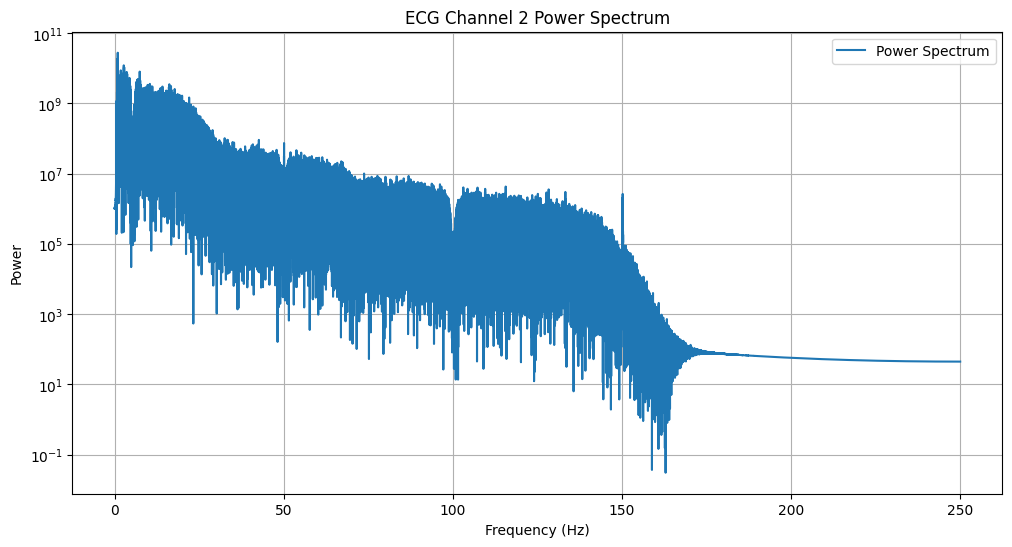

In [20]:
filtered_ecg_fft = np.fft.fft(ecg_signal[:, 1])  # FFT of the filtered second channel
freqs = np.linspace(0, header['ecg']['samplingRate']/2, len(filtered_ecg_fft)//2 + 1)
power_spectrum = np.abs(filtered_ecg_fft[:len(freqs)])**2

plt.figure(figsize=(12, 6))
plt.plot(freqs, power_spectrum[:len(freqs)], label='Power Spectrum')
plt.yscale('log')
plt.grid(True)
plt.title('ECG Channel 2 Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

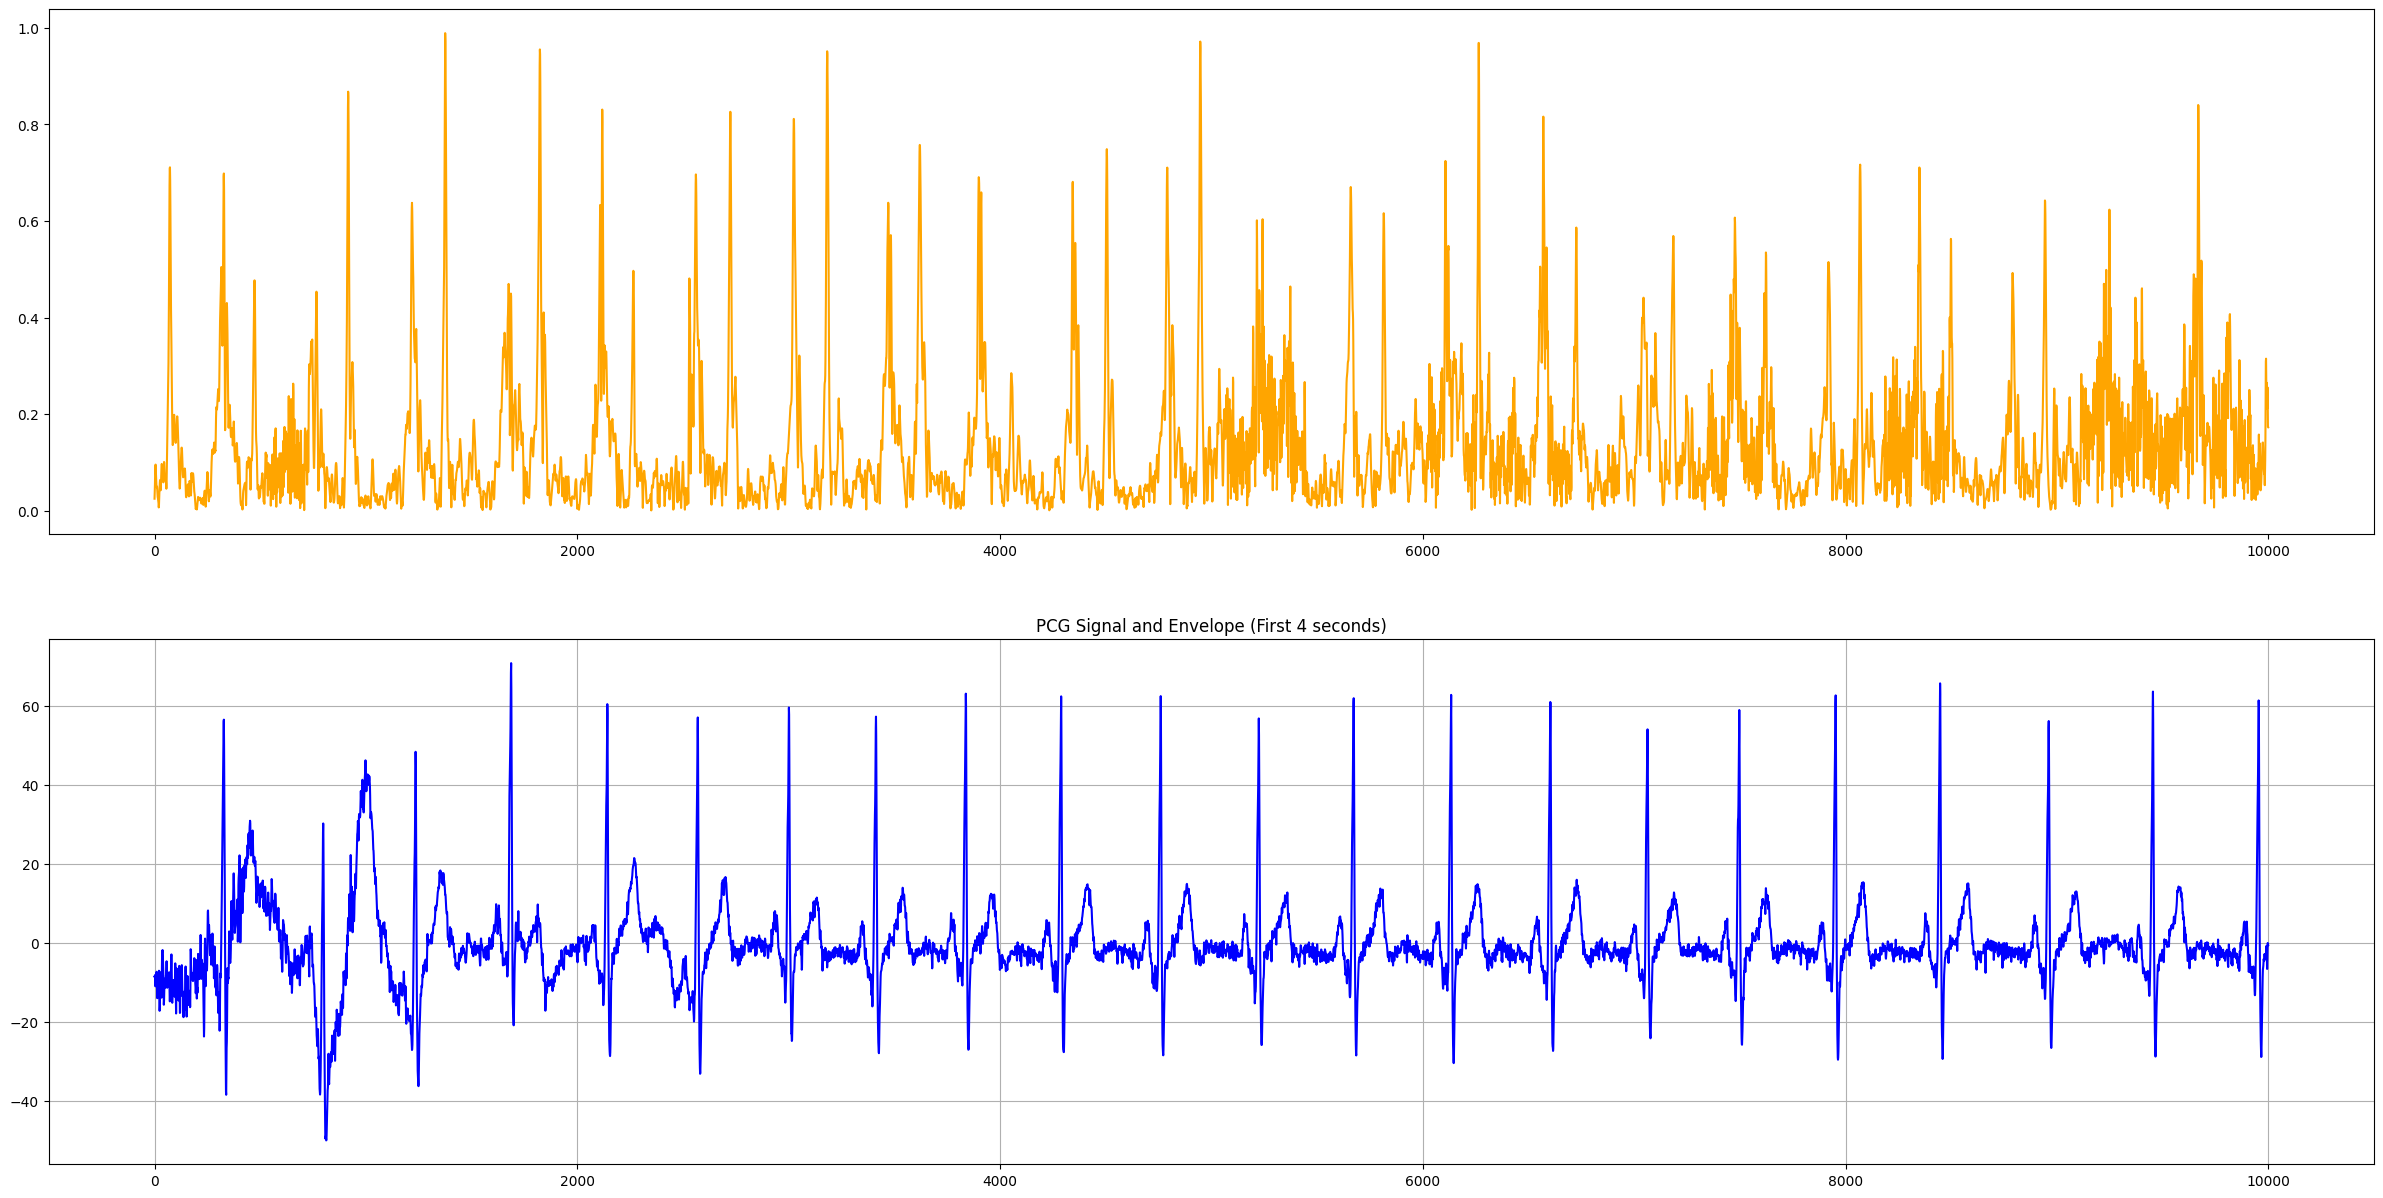

In [10]:
from scipy.io.wavfile import read as wavread

fs, pcg = wavread('denoised_pcg_kalman_1kHz.wav')
pcg = decimate(pcg, 2)  # Downsample to 500 Hz
envol = envelope(pcg, residual=None)

plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)
plt.plot(envol[:10000], label='Envelope', color='orange')
plt.subplot(2, 1, 2)
plt.plot(ecg_signal[256:10000+256, 1], label='PCG Signal', color='blue')
plt.title('PCG Signal and Envelope (First 4 seconds)')
plt.grid(True)
plt.show()

In [7]:
np.argmax(envol[200:400]), np.argmax(ecg_signal[500:750, 1])

(np.int64(128), np.int64(84))

In [ ]:
from ecgdetectors import Detectors
# Combined normalization function
def normalize(signal: np.ndarray) -> np.ndarray:
    """Normalize signal to [0,1] handling NaNs gracefully."""
    s = np.asarray(signal, dtype=float)
    if s.size == 0:
        return s
    # Use nan-aware min/max to avoid propagating NaNs
    s_min = np.nanmin(s)
    s_max = np.nanmax(s)
    denom = (s_max - s_min)
    if not np.isfinite(denom) or denom == 0:
        # Flat or invalid; return zeros
        return np.nan_to_num(s - s_min)
    return np.nan_to_num((s - s_min) / denom)
    
# Find R-peaks in the ECG signal
def find_r_peaks(ecg_signal, fs=300):
    ecg_channel = normalize(ecg_signal).astype(np.float32)
    detectors = Detectors(fs)
    return detectors.engzee_detector(ecg_channel)

r_peaks = np.array(find_r_peaks(ecg_signal[:, 1], fs=fs))

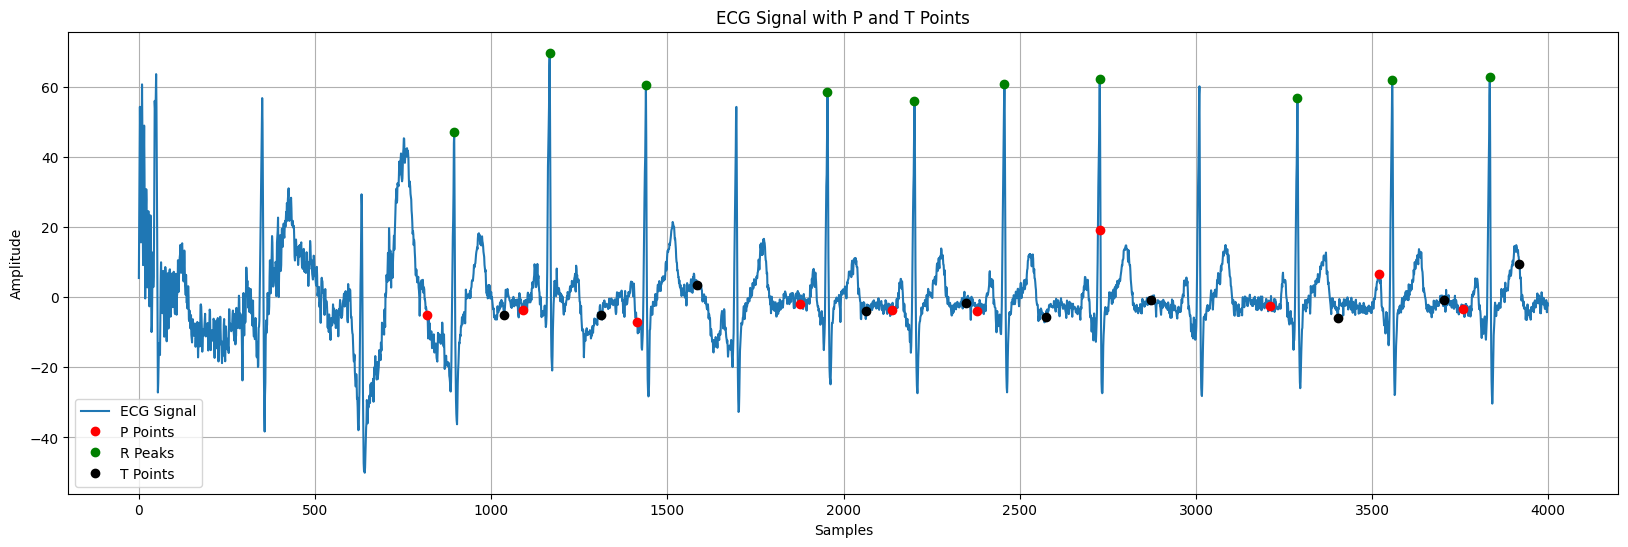

In [29]:
x = np.arange(len(ecg_300Hz))

plt.figure(figsize=(20, 6))
plt.plot(ecg_300Hz[:4000, 1], label='ECG Signal')
plt.plot(x[P_points[:10]], ecg_300Hz[P_points[:10], 1], 'ro', label='P Points')
plt.plot(x[r_peaks[:10]], ecg_300Hz[r_peaks[:10], 1], 'go', label='R Peaks')
plt.plot(x[T_points[:10]], ecg_300Hz[T_points[:10], 1], 'ko', label='T Points')
plt.title('ECG Signal with P and T Points')
plt.grid(True)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()